In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pingouin as pg
import plotly.express as px 
import plotly.io as pio
# pio.renderers.default='browser'

In [3]:
# Objetivo: agrupar os clientes de uma operadora de cartão de crédito
# Analisar os grupos de clientes mais e menos leais à marca (por meio do uso)

dados_cartao = pd.read_csv('data/cartao_credito.csv')
## Fonte: https://www.kaggle.com/datasets/aryashah2k/credit-card-customer-data

In [4]:
# Estrutura do banco de dados

print(dados_cartao.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB
None


In [5]:
# Estatísticas descritivas das variáveis

# Primeiramente, vamos excluir as variáveis que não serão utilizadas

cartao_cluster = dados_cartao.drop(columns=['Sl_No', 'Customer Key'])

# Obtendo as estatísticas descritivas das variáveis

tab_descritivas = cartao_cluster.describe().T

*Vamos padronizar as variáveis antes da clusterização!*

In [6]:
# Padronização por meio do Z-Score

# Aplicando o procedimento de ZScore
cartao_pad = cartao_cluster.apply(zscore, ddof=1)

# Visualizando o resultado do procedimento na média e desvio padrão
print(round(cartao_pad.mean(), 3))
print(round(cartao_pad.std(), 3))

Avg_Credit_Limit       0.0
Total_Credit_Cards     0.0
Total_visits_bank      0.0
Total_visits_online    0.0
Total_calls_made      -0.0
dtype: float64
Avg_Credit_Limit       1.0
Total_Credit_Cards     1.0
Total_visits_bank      1.0
Total_visits_online    1.0
Total_calls_made       1.0
dtype: float64


In [7]:
# Gráfico 3D das observações

fig = px.scatter_3d(cartao_pad, 
                    x='Avg_Credit_Limit', 
                    y='Total_Credit_Cards', 
                    z='Total_visits_bank')
fig.show()

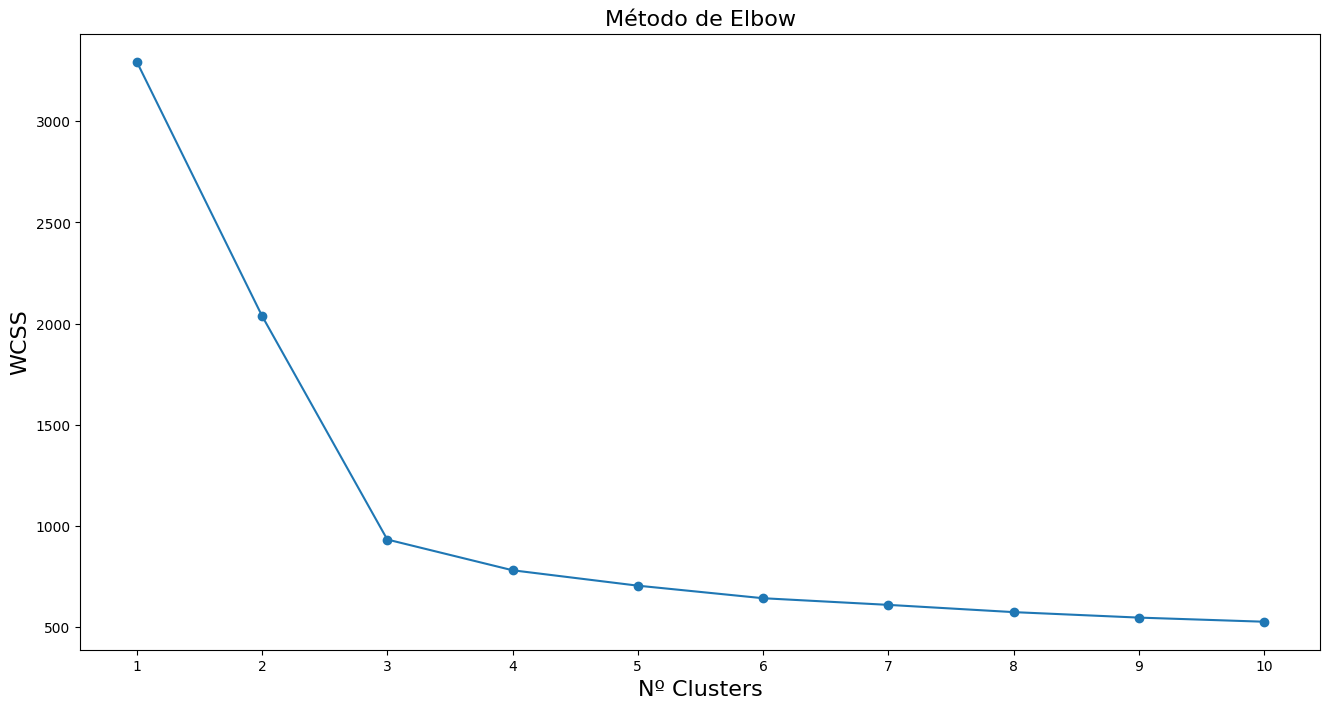

In [8]:
# Identificação da quantidade de clusters (Método Elbow)

elbow = []
K = range(1,11) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(cartao_pad)
    elbow.append(kmeanElbow.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,11)) # ajustar range
plt.ylabel('WCSS', fontsize=16)
plt.title('Método de Elbow', fontsize=16)
plt.show()

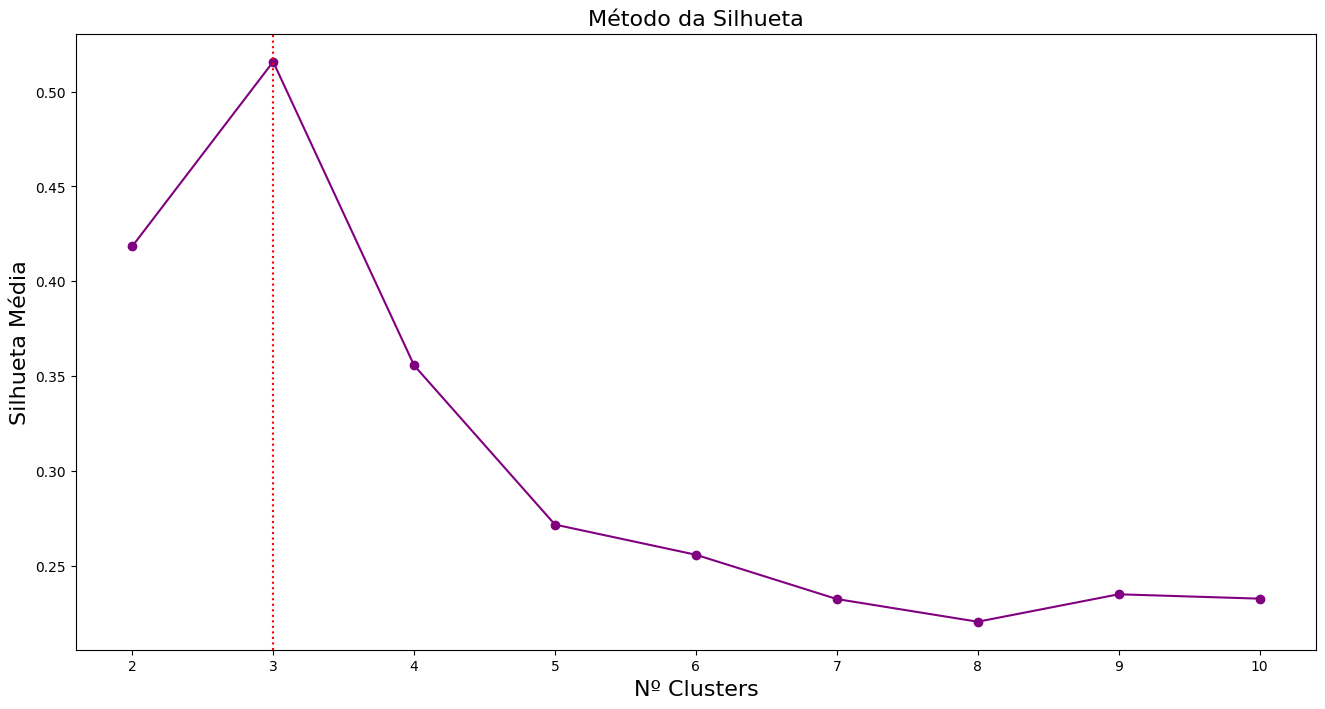

In [9]:
# Identificação da quantidade de clusters (Método da Silhueta)

silhueta = []
I = range(2,11) # ponto de parada pode ser parametrizado manualmente
for i in I: 
    kmeansSil = KMeans(n_clusters=i, init='random', random_state=100).fit(cartao_pad)
    silhueta.append(silhouette_score(cartao_pad, kmeansSil.labels_))

plt.figure(figsize=(16,8))
plt.plot(range(2, 11), silhueta, color = 'purple', marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Silhueta Média', fontsize=16)
plt.title('Método da Silhueta', fontsize=16)
plt.axvline(x = silhueta.index(max(silhueta))+2, linestyle = 'dotted', color = 'red') 
plt.show()

In [10]:
# Cluster Não Hierárquico K-means

# Vamos considerar 3 clusters, considerando as evidências anteriores!

kmeans_final = KMeans(n_clusters = 3, init = 'random', random_state=100).fit(cartao_pad)

# Gerando a variável para identificarmos os clusters gerados

kmeans_clusters = kmeans_final.labels_
cartao_cluster['cluster_kmeans'] = kmeans_clusters
cartao_pad['cluster_kmeans'] = kmeans_clusters
cartao_cluster['cluster_kmeans'] = cartao_cluster['cluster_kmeans'].astype('category')
cartao_pad['cluster_kmeans'] = cartao_pad['cluster_kmeans'].astype('category')

In [11]:
# Análise de variância de um fator (ANOVA)

# Interpretação do output:

## cluster_kmeans MS: indica a variabilidade entre grupos
## Within MS: indica a variabilidade dentro dos grupos
## F: estatística de teste (cluster_kmeans MS / Within MS)
## p-unc: p-valor da estatística F
## se p-valor < 0.05: pelo menos um cluster apresenta média estatisticamente diferente dos demais

# Avg_Credit_Limit
print("Avg_Credit_Limit")
display(pg.anova(dv='Avg_Credit_Limit', 
         between='cluster_kmeans', 
         data=cartao_pad,
         detailed=True).T)

# Total_Credit_Cards
print("Total_Credit_Cards")
display(pg.anova(dv='Total_Credit_Cards', 
         between='cluster_kmeans', 
         data=cartao_pad,
         detailed=True).T)

# Total_visits_bank
print("Total_visits_bank")
display(pg.anova(dv='Total_visits_bank', 
         between='cluster_kmeans', 
         data=cartao_pad,
         detailed=True).T)

# Total_visits_online
print("Total_visits_online")
display(pg.anova(dv='Total_visits_online', 
         between='cluster_kmeans', 
         data=cartao_pad,
         detailed=True).T)

# Total_calls_made
print("Total_calls_made")
display(pg.anova(dv='Total_calls_made', 
         between='cluster_kmeans', 
         data=cartao_pad,
         detailed=True).T)

Avg_Credit_Limit


,0,1
Source,cluster_kmeans,Within
SS,479.901385,179.098615
DF,2,657
MS,239.950692,0.272601
F,880.227938,NaN
p-unc,0.0,NaN
np2,0.728227,NaN


Total_Credit_Cards


,0,1
Source,cluster_kmeans,Within
SS,478.078715,180.921285
DF,2,657
MS,239.039358,0.275375
F,868.050755,NaN
p-unc,0.0,NaN
np2,0.725461,NaN


Total_visits_bank


,0,1
Source,cluster_kmeans,Within
SS,413.975651,245.024349
DF,2,657
MS,206.987826,0.372944
F,555.010154,NaN
p-unc,0.0,NaN
np2,0.628188,NaN


Total_visits_online


,0,1
Source,cluster_kmeans,Within
SS,540.564886,118.435114
DF,2,657
MS,270.282443,0.180267
F,1499.348962,NaN
p-unc,0.0,NaN
np2,0.820281,NaN


Total_calls_made


,0,1
Source,cluster_kmeans,Within
SS,450.849316,208.150684
DF,2,657
MS,225.424658,0.31682
F,711.523007,NaN
p-unc,0.0,NaN
np2,0.684142,NaN


In [12]:
# Gráfico 3D dos clusters

# Perspectiva 1

fig = px.scatter_3d(cartao_cluster, 
                    x='Avg_Credit_Limit', 
                    y='Total_Credit_Cards', 
                    z='Total_visits_online',
                    color='cluster_kmeans')
fig.show()

In [13]:
# Perspectiva 2

fig = px.scatter_3d(cartao_cluster, 
                    x='Avg_Credit_Limit', 
                    y='Total_Credit_Cards', 
                    z='Total_visits_bank',
                    color='cluster_kmeans')
fig.show()

In [14]:
# Perspectiva 3

fig = px.scatter_3d(cartao_cluster, 
                    x='Avg_Credit_Limit', 
                    y='Total_Credit_Cards', 
                    z='Total_calls_made',
                    color='cluster_kmeans')
fig.show()

In [15]:
# Identificação das características dos clusters

# Agrupando o banco de dados

cartao_grupo = cartao_cluster.groupby(by=['cluster_kmeans'])

# Estatísticas descritivas por grupo

tab_desc_grupo = cartao_grupo.describe().T

C:\Users\guilh\AppData\Local\Temp\ipykernel_15988\1273175098.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

